In [90]:
# -*- coding: utf-8 -*-
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd 
import random
from keras.models import load_model
import os
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [175]:
class environment:
    def __init__(self, stock_1 ,stock_2 ,capital ,window_size, moving_average_size):
        self.action_space = [0.25,0.1,0.05,0,0.05,0.1,0.25]
        self.stocks = [stock_1,stock_2]
        self.capital = capital
        # Create feature of both stock
        self.feature, self.close_price, self.open_price = self.create_feature(window_size,moving_average_size,stock_1,stock_2)
        # Get the id of last day in data
        self.last_day_number = self.close_price.shape[0]-1
        ### Build the variable
        ### *** Note that the value will be assigned in reset function
        ###    - day id 
        self.day = 0
        ###    - Random initial portfolio
        self.initial_portfolio = 0
        ###    - Create the number of share of each stock
        self.amount_share = 0
        ###    - Current portfolio value
        self.current_portfolio_value = 0
        ###    - done
        self.done = False
        
    def reset(self):
        self.day = 0
        self.done = False
        self.initial_portfolio = np.array([0.5,0.5])
        self.amount_share = self.capital*self.initial_portfolio/self.open_price[self.day]
        self.current_portfolio_value = self.cal_portfolio_value_at_the_end_of_day()
        #### Create state 
        state = np.hstack((self.feature[self.day],self.current_portfolio_value/np.sum(self.current_portfolio_value)))
        return state
        
    def step(self,action_id):
        action = self.action_space[action_id]
        ### Calculate the portfolio value according to the action
        if action_id<3:
            ### If action_id <3, then sell x% of values of stock 1 and buy the corresponding amount of stock2 
            adjust_amount = self.current_portfolio_value[0]*action
            new_portfolio_fraction = [ self.current_portfolio_value[0] - adjust_amount\
                                      ,self.current_portfolio_value[1] + adjust_amount]
        elif action_id>3:
            ### If action_id >3, then sell x% of values of stock 2 and buy the corresponding amount of stock1 
            adjust_amount = self.current_portfolio_value[1]*action
            new_portfolio_fraction = [ self.current_portfolio_value[0] + adjust_amount\
                                      ,self.current_portfolio_value[1] - adjust_amount]
        else:
            ### If action_id = 3, then do nothing
            new_portfolio_fraction = self.current_portfolio_value
            
        ### Shift to next day
        self.day += 1
        ###    - if the final day in data have been reached, then done = true
        if self.day == self.last_day_number: self.done = True
            
        ### Update portfolio (buy at open price of the day)
        ###      **** Note that the open price is the close price of the previous day
        self.amount_share = new_portfolio_fraction/self.open_price[self.day]
        
        ### Calculate reward
        ###    - Store old portfolio value
        total_old_portfolio_value = np.sum(self.current_portfolio_value)
        ###    - Calculate new portfolio value
        self.current_portfolio_value = self.cal_portfolio_value_at_the_end_of_day()
        ###    - Calculate reward
        total_current_portfolio_value = np.sum(self.current_portfolio_value)
        reward =  100.0*(total_current_portfolio_value-total_old_portfolio_value)/total_old_portfolio_value
        
        ### Create state
        ###    - stock feature
        stock_feature = self.feature[self.day]
        ###    - proportion feature
        proportion_feature = self.current_portfolio_value/np.sum(self.current_portfolio_value)
        ###    - merge features
        next_state = np.hstack((self.feature[self.day],proportion_feature))
        
        return next_state,reward,self.done
    
    def cal_portfolio_value_at_the_end_of_day(self):
        return self.amount_share*self.close_price[self.day]

    def feature_of_stock(self, stock, window_size, moving_average_size):
        ### Read data and select only close price
        price = pd.read_csv(stock)[['Close']][:3200]
        ### Assume that open price is the close price of previous day
        price['Open'] = price.shift(1)
        ### Calculate the EMA of price for reducing the noise in series
        price['EMA'] = price['Open'].ewm(span=moving_average_size, adjust=False).mean()
        ### Lag the ema price for (window_size+1) time
        for i in range(window_size+1):
            price['EMA_lag{}'.format(i)] = price['EMA'].shift(i)
        ### Create percent change between each consecutive day (0-100%)
        for i in range(window_size):
            price['percent_change_EMA{}'.format(i+1)] = (price['EMA_lag{}'.format(i)]-price['EMA_lag{}'.format(i+1)])*100\
                                                        /price['EMA_lag{}'.format(i+1)]
        price = price.dropna()
        ### Select only the percent change as the feature
        feature = np.array(price[['percent_change_EMA{}'.format(i+1) for i in range(window_size)]].values.tolist())
        ### Return feature as feature, 
        ###        price['close'] as the sell price at that day,
        ###        price[lag] as a buy price at that day
        return feature,price['Close'],price['Open']
    
    def create_feature(self,\
                       window_size = 7,\
                       moving_average_size = 3,\
                       stock1 = '../../Thesis/Data/high_volatile/APA.csv',\
                       stock2 = '../../Thesis/Data/low_volatile/JNJ.csv'):
        ### Generate feature of each stock
        feature_1,close_price_1,open_price_1 = self.feature_of_stock(stock1,window_size,moving_average_size)
        feature_2,close_price_2,open_price_2 = self.feature_of_stock(stock2,window_size,moving_average_size)
        ### Concat feature from 2 stocks to be one features
        feature = np.concatenate([feature_1,feature_2],axis=1)
        ### Concat buy price and sell price to format [[<buyorsell>ofstock1,<buyorsell>ofstock2], [],[]]
        ### example of buy price
        ###                 [[buy price of stock 1 in day 0, buy price of stock 2 in day 0]
        ###                  [buy price of stock 1 in day 1, buy price of stock 2 in day 2],....]
        close_price = np.stack((close_price_1,close_price_2),axis=-1)
        open_price = np.stack((open_price_1,open_price_2),axis=-1)
        return feature,close_price,open_price

In [176]:
class Agent:
    def __init__(self, model_path):
        self.model = load_model(model_path)
        
    def act(self, state):
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

# Parameter

In [177]:
window_size = 7
moving_average_size = 3
capital = 100000000.0
high_beta_stock = 'APA'
low_beta_stock = 'JNJ'
state_size = window_size*2 + 2

In [178]:
env = environment('../../Thesis/Data/high_volatile/{}.csv'.format(high_beta_stock)\
                  ,'../../Thesis/Data/low_volatile/{}.csv'.format(low_beta_stock)\
                  ,capital\
                  ,window_size\
                  ,moving_average_size)

# Benchmark History

In [166]:
portfolio_value_hist = {}

# Trained Agent

In [167]:
for n_ep in range(0,8):
    trainAgent = Agent('model/{}.h5'.format(n_ep))
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    portfolio_value = []
    action_list = []
    while True:
        # env.render()
        action = trainAgent.act(state)
        next_state, reward, done = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        state = next_state
        portfolio_value.append(env.current_portfolio_value)
        action_list.append(action)
        if done:
            break
    portfolio_value_hist['model{}'.format(n_ep)] =  portfolio_value

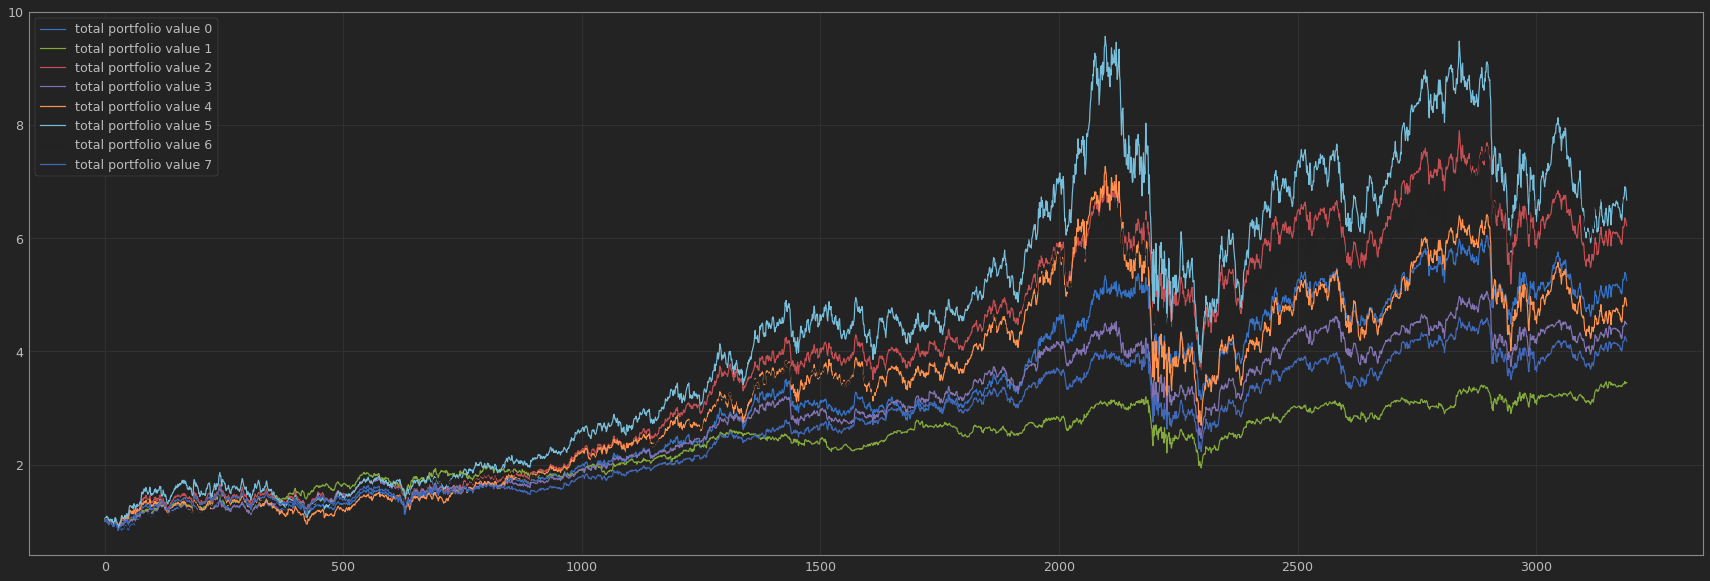

In [168]:
plt.figure(figsize=(30,10))
for n_ep in range(0,8):
    plt.plot((np.sum(np.array(portfolio_value_hist['model{}'.format(n_ep)]),axis=1)/capital) , label = 'total portfolio value {}'.format(n_ep))
plt.legend()

# Do Nothing

In [169]:
state = env.reset()
state = np.reshape(state, [1, state_size])
portfolio_value = []
action_list = []
while True:
    # env.render()
    action = 3
    next_state, reward, done = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    state = next_state
    portfolio_value.append(env.current_portfolio_value)
    action_list.append(action)
    if done:
        break
portfolio_value_hist['do_nothing'] =  portfolio_value

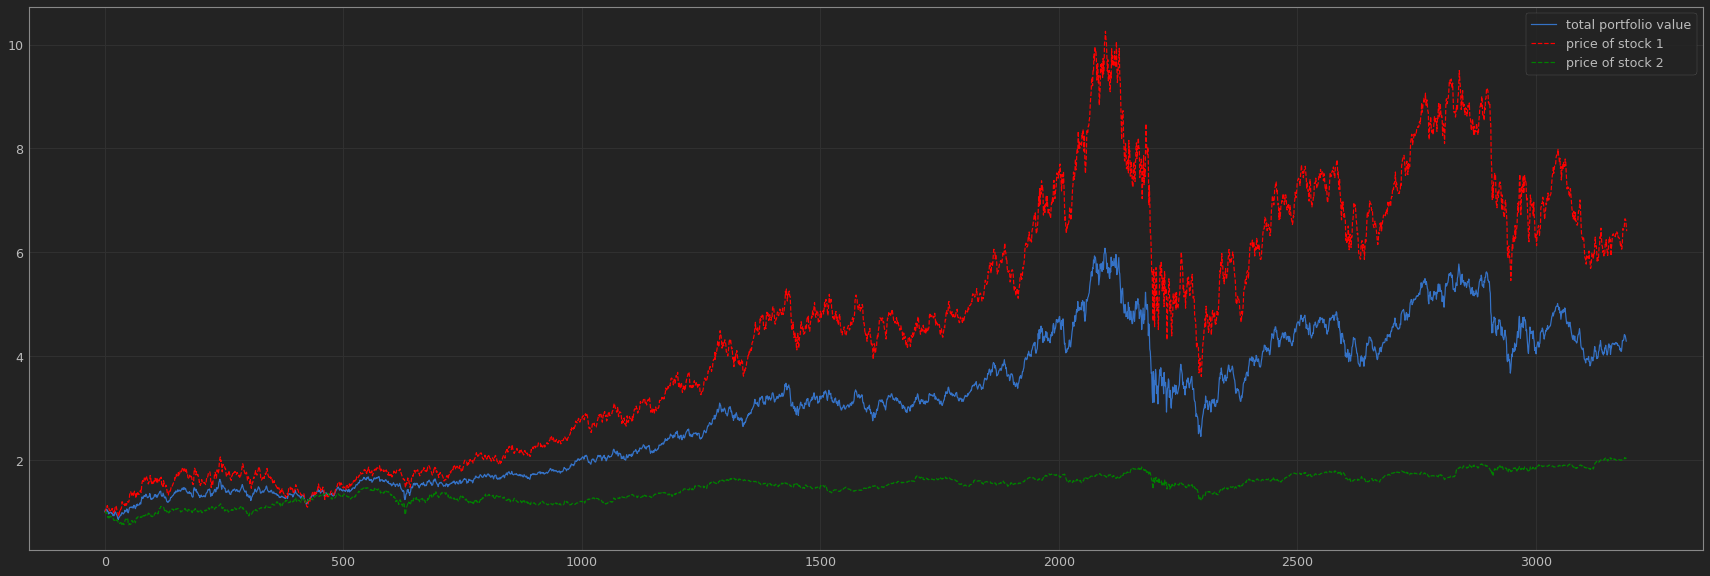

In [170]:
plt.figure(figsize=(30,10))
# plt.plot(np.array(portfolio_value)/capital, label = 'portfolio value for stock 1 and 2')
plt.plot(np.sum(np.array(portfolio_value),axis=1)/capital , label = 'total portfolio value')
plt.plot(env.close_price[:,0]/env.close_price[0][0], c='red' , label = 'price of stock 1' , linestyle='dashed')
plt.plot(env.close_price[:,1]/env.close_price[0][1], c='green', label = 'price of stock 2' , linestyle='dashed')
plt.legend()

# Random

In [171]:
state = env.reset()
state = np.reshape(state, [1, state_size])
portfolio_value = []
action_list = []
while True:
    # env.render()
    action = random.randint(0,6)
    next_state, reward, done = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    state = next_state
    portfolio_value.append(env.current_portfolio_value)
    action_list.append(action)
    if done:
        break
portfolio_value_hist['random'] =  portfolio_value

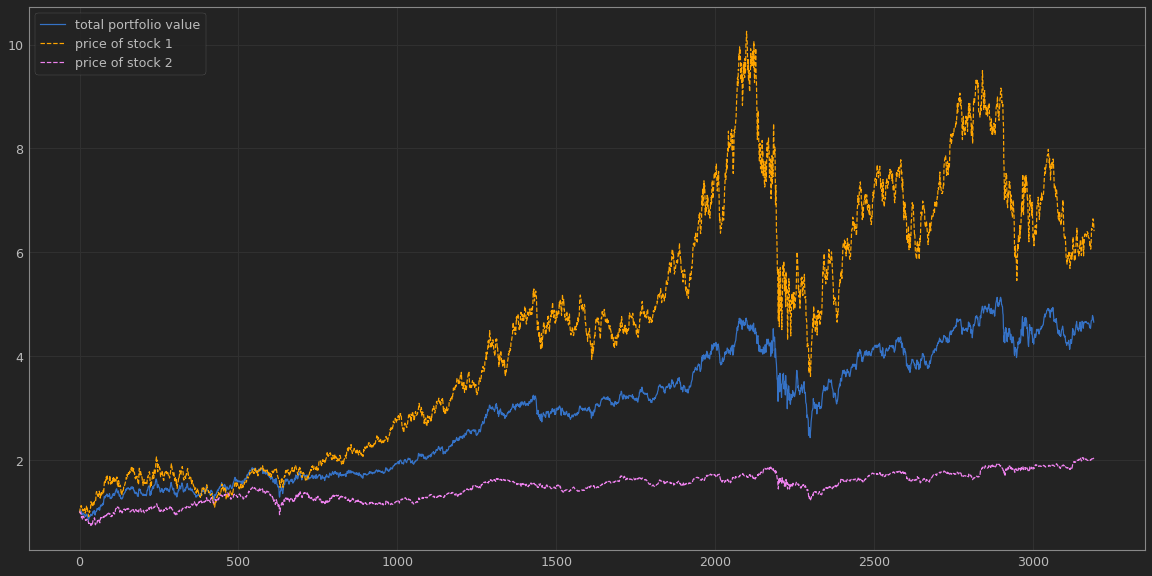

In [172]:
plt.figure(figsize=(20,10))
# plt.plot(np.array(portfolio_value)/capital, label = 'portfolio value for stock 1 and 2')
plt.plot(np.sum(np.array(portfolio_value),axis=1)/capital , label = 'total portfolio value')
plt.plot(env.close_price[:,0]/env.close_price[0][0], c='orange' , label = 'price of stock 1' , linestyle='dashed')
plt.plot(env.close_price[:,1]/env.close_price[0][1], c='violet', label = 'price of stock 2' , linestyle='dashed')
plt.legend()

# Plot Result

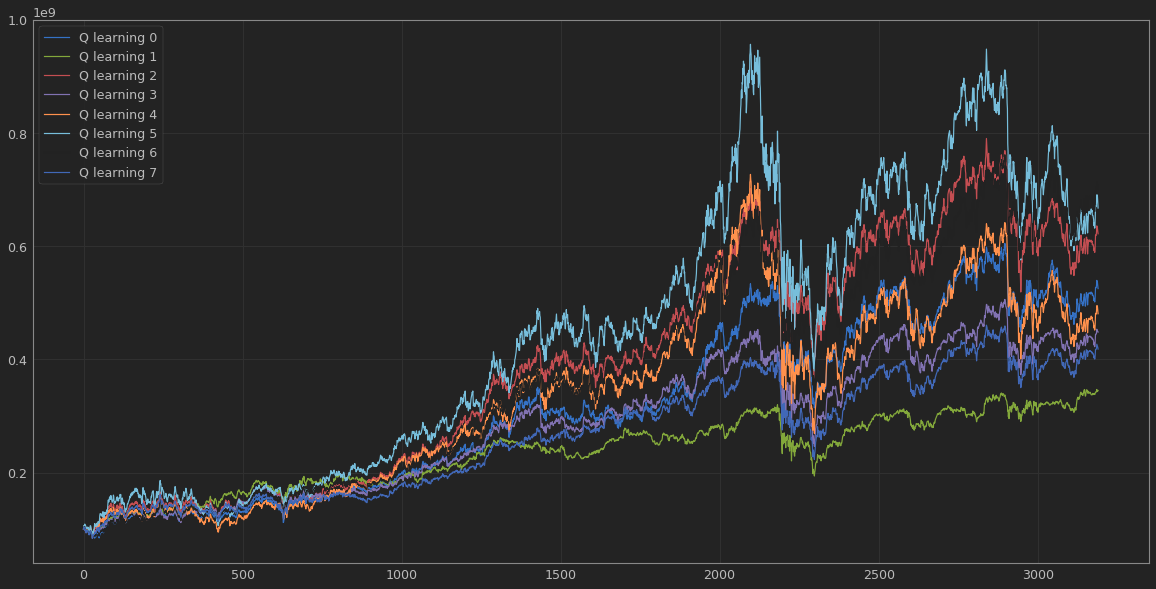

In [173]:
plt.figure(figsize=(20,10))
for n_ep in range(0,8):
    plt.plot((np.sum(np.array(portfolio_value_hist['model{}'.format(n_ep)]),axis=1)) , label = 'Q learning {}'.format(n_ep))
# plt.plot(np.sum(portfolio_value_hist['do_nothing'],axis=1),c='r', label='buy and hold')
# plt.plot(np.sum(portfolio_value_hist['random'],axis=1),c='b', label='random')
plt.legend()

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(env.close_price[:,0], label = 'price of stock1')
plt.plot(env.close_price[:,1], label = 'price of stock2')
plt.legend()